# COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [123]:
#see online at https://covid19-jyy3.onrender.com/analysis

In [124]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54349  100 54349    0     0   124k      0 --:--:-- --:--:-- --:--:--  124k


In [125]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [126]:
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

In [127]:
#suppress annoying warnings about pandas assignment
pd.options.mode.chained_assignment = None
#suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [128]:
#format x axis with dates
def format_x_date(ax):
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))





def get_country_data(selection):
    selection = selection.iloc[:,4:].T
    selection.columns=['Death']
    selection['Death_change']=selection['Death']-selection['Death'].shift(1)
    selection=selection.reset_index()
    selection['index'] = pd.to_datetime(selection['index'])
    selection['Death_change_log']=np.log10(selection['Death_change'])
    selection['Death_change_log']=selection['Death_change_log'].replace(-np.inf,np.nan)
    selection=selection[~selection['Death_change_log'].isna()]
    selection.columns=['date']+list(selection.columns[1:])
    selection['ndate']=date2num(selection['date'])
    return selection



# Load national dataset

In [129]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,93,3.0,35,10,0.477121
2,78,2.0,36,12,0.301030
3,250,5.0,56,17,0.698970
4,238,4.0,64,21,0.602060


In [130]:
df.tail()

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,...,note_en,ricoverati_con_sintomi_change,terapia_intensiva_change,deceduti_daily,not_admitted_ratio,not_admitted,nuovi_positivi_log,deceduti_daily_log,terapia_intensiva_log,deceduti_log
45,2020-04-09 17:00:00,28399,3605,32004,64873,96877,1615,4204,28470,18279,...,NaN,-86.0,-88.0,610.0,-6.931818,698.0,3.623663,2.785330,3.556905,4.261952
46,2020-04-10 17:00:00,28242,3497,31739,66534,98273,1396,3951,30455,18849,...,pd-EN-0011,-157.0,-108.0,570.0,-5.277778,678.0,3.596707,2.755875,3.543696,4.275288
47,2020-04-11 17:00:00,28144,3381,31525,68744,100269,1996,4694,32534,19468,...,NaN,-98.0,-116.0,619.0,-5.336207,735.0,3.671543,2.791691,3.529045,4.289321
48,2020-04-12 17:00:00,27847,3343,31190,71063,102253,1984,4092,34211,19899,...,dc-EN-0003,-297.0,-38.0,431.0,-11.342105,469.0,3.611936,2.634477,3.524136,4.298831
49,2020-04-13 17:00:00,28023,3260,31283,72333,103616,1363,3153,35435,20465,...,NaN,176.0,-83.0,566.0,-6.819277,649.0,3.498724,2.752816,3.513218,4.311012


## Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

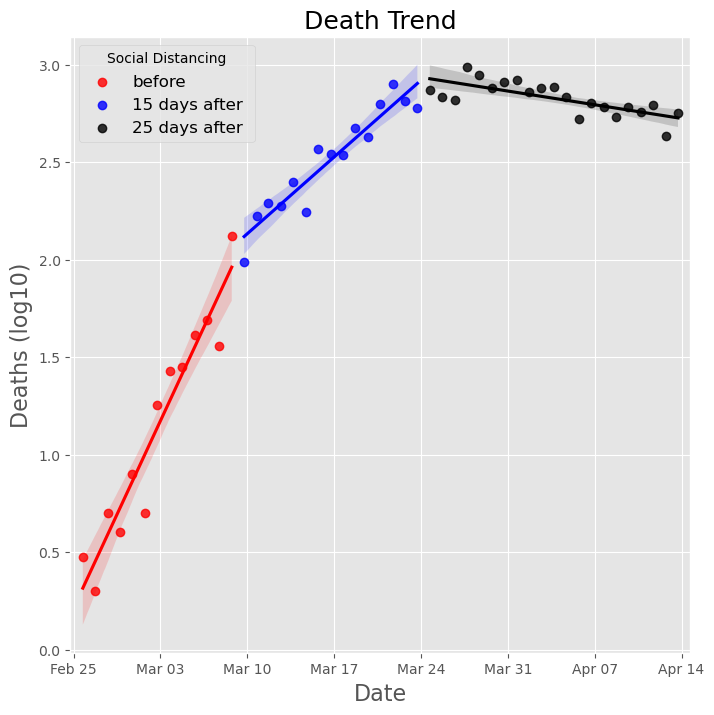

In [131]:
plt.style.use('ggplot')
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
after['ndata']=date2num(after['data'])

after2 = df[(df['data']>='2020-03-24')  ]
after2['ndata']=date2num(after2['data'])

x='ndata'
y='deceduti_daily_log'
fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')
format_x_date(ax)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-1,xmax+1)
#plt.xticks(rotation=70,ha='right')
plt.xlabel('Date', fontsize='16')
plt.ylabel('Deaths (log10)',fontsize='16')
plt.title('Death Trend',fontsize='18')
plt.legend(title='Social Distancing',fontsize=12)
plt.savefig('Fig1.png')
plt.show()

## Fig2 
How many more people die in Italy respect to the people admitted in intensive care?

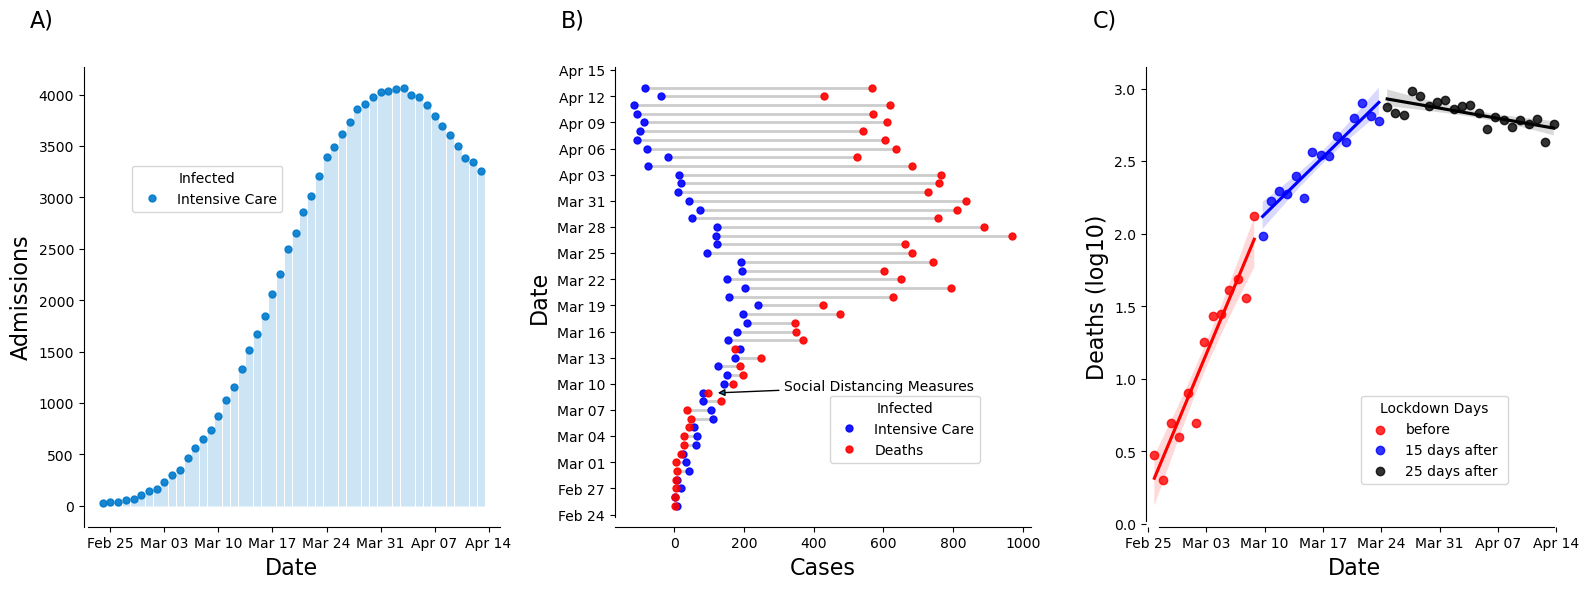

In [132]:
#plt.style.use('ggplot')

def despine(ax,log_y=False):
    small_add=1.1
    if log_y:
        small_add = np.log10(1.1)    
    ymin, ymax = ax.get_ylim()
    #ax.set_ylim(ymin+small_add,ymax)

    ax.spines['left'].set_bounds(ymin+small_add, ymax)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    xmin, xmax = ax.get_xlim()
    #ax.set_xlim(xmin,xmax)

    ax.spines['bottom'].set_bounds(xmin+0.5, xmax)
    
def lollipop_plot(df, ax, date_col='data', value_col='not_admitted_ratio',
                 color='#007acc',label='Ratio'):
    #make lollipop
    ax.plot(df[date_col].dt.date, df[value_col], "o",
        markersize=5, color=color, alpha=0.9,label=label)
    #make stick
    ax.vlines(x=df[date_col].dt.date, ymin=0, 
          ymax=df[value_col], color=color, alpha=0.2, linewidth=5)

    #set ticks every week
    despine(ax)
    format_x_date(ax)
    
    return ax

def my_plot(df, ax, date_col='data', 
            #value_3='ricoverati_con_sintomi_change',
            value_2='terapia_intensiva_change',
            value_1='deceduti_daily',
            
            label_1='Deaths',
            label_2="Intensive Care",
            #label_3="Hospital Admissions",
           ):
    #make lollipop
    #ax.plot(df[value_3], df[date_col].dt.date, "o",
    #    markersize=5, color='green', alpha=0.9,label=label_3)    
    ax.plot(df[value_2], df[date_col].dt.date, "o",
        markersize=5, color='blue', alpha=0.9,label=label_2)
    ax.plot(df[value_1], df[date_col].dt.date, "o",
        markersize=5, color='red', alpha=0.9,label=label_1)

    
    xmin=df[[value_1,value_2]].min(axis=1)
    xmax=df[[value_1,value_2]].max(axis=1)
    #make stick
    ax.hlines(y=df[date_col].dt.date, xmin=xmin,
              xmax=xmax, color='black', alpha=0.2, linewidth=2)

    
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim(ymin,ymax)
    #ax.spines['left'].set_bounds(ymin, ymax-0.5)
    despine(ax)
    #set ticks every 3 days
    #ax.yaxis.set_major_locator(mdates.WeekdayLocator())
    ax.yaxis.set_major_locator(mdates.DayLocator(interval=3))
    #set major ticks format
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    #ax.spines['top'].set_color('none')
    #ax.spines['right'].set_color('none')
    #xmin, xmax = ax.get_xlim()
    #ax.spines['bottom'].set_bounds(0, xmax-1)
    return ax


plt.style.use('default')
from matplotlib.patches import Ellipse

fig,axes=plt.subplots(figsize=(16,6
                              ),ncols=3)

ax=axes[1]
ax = my_plot(df, ax)
df['ndate']=date2num(df['data'])

ax.set_xlabel('Cases', fontsize='16')
ax.set_ylabel('Date', fontsize='16')

ax.annotate('Social Distancing Measures', 
            (df['deceduti_daily'][14]+20, mdates.date2num(df['data'][13])+0.2 ),
            xytext=(50, 2), 
            textcoords='offset points', 
            arrowprops=dict(arrowstyle='-|>'))
ax.text(-0.1, 1.1, 'B)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Infected')
ax=axes[0]
ax = lollipop_plot(df, ax, date_col='data',
                   value_col='terapia_intensiva',label='Intensive Care')

ax.legend(loc=2, bbox_to_anchor=(0.1, 0.8), title='Infected')

ax.set_xlabel('Date', fontsize='16')
ax.set_ylabel('Admissions', fontsize='16')
ax.text(-0.1, 1.1, 'A)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)


ax=axes[2]
before = df[df['data']<'2020-03-9']
before['ndata']=date2num(before['data'])
after = df[(df['data']>'2020-03-9') & (df['data']<'2020-03-24') ]
after['ndata']=date2num(after['data'])

after2 = df[(df['data']>='2020-03-24')  ]
after2['ndata']=date2num(after2['data'])

x='ndata'
y='deceduti_daily_log'
#fig,ax=plt.subplots(figsize=(8,8))
sns.regplot(x=x, y=y, color="r", data=before,ax=ax,label='before')
sns.regplot(x=x, y=y, color="b", data=after,ax=ax,label='15 days after ')
sns.regplot(x=x, y=y, color="black", data=after2,ax=ax,label='25 days after')


despine(ax,log_y=True)
format_x_date(ax)
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin-1,xmax+1)


ax.set_xlabel('Date', fontsize='16')
ax.set_ylabel('Deaths (log10)',fontsize='16')
ax.text(-0.1, 1.1, 'C)', horizontalalignment='center', 
               verticalalignment='center',
               transform=ax.transAxes,fontsize=16)

plt.tight_layout()
ax.legend(loc=2, bbox_to_anchor=(0.5, 0.3), title='Lockdown Days')
plt.savefig('Fig2b.png')
plt.show()


## Extract UK data

In [133]:
allDf = pd.read_csv('deaths_global.csv')
temp = allDf[(allDf['Country/Region']=='United Kingdom') & (allDf['Lat']==55.3781)  ]
uk_df =  get_country_data(temp)   

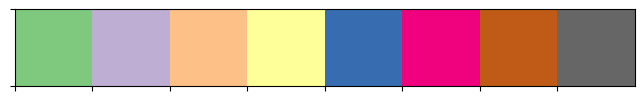

In [134]:
sns.palplot(sns.color_palette("Accent"))
palette=sns.color_palette("Accent")

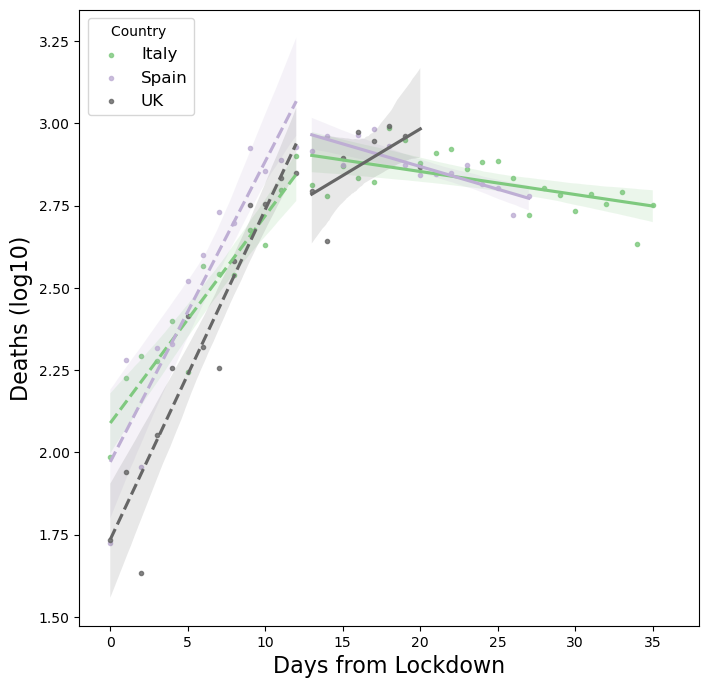

In [135]:
{'visible':False}
fig,ax=plt.subplots(figsize=(8,8))
temp = df[df['data']>'2020-03-9']
temp['days_from_lockdown']=np.arange(0,df[df['data']>'2020-03-9'].shape[0])

sns.regplot(x='days_from_lockdown',y='deceduti_daily_log'
            ,data=temp.iloc[0:13],fit_reg=True,color=palette[0],
           marker='.',line_kws={'linestyle':'--'}) 
sns.regplot(x='days_from_lockdown',y='deceduti_daily_log',
            data=temp.iloc[13:],fit_reg=True,color=palette[0],
            label='Italy',marker='.') 


spain_df = allDf[(allDf['Country/Region']=='Spain')]
spain_df =  get_country_data(spain_df)
spain_df = spain_df[spain_df['date']>='2020-03-16']
spain_df['days_from_lockdown']=np.arange(0,spain_df.shape[0])


sns.regplot(x='days_from_lockdown',y='Death_change_log'
            ,data=spain_df.iloc[0:13],fit_reg=True,color=palette[1],
            marker='.',line_kws={'linestyle':'--'}) 
sns.regplot(x='days_from_lockdown',y='Death_change_log',
            data=spain_df.iloc[13:],fit_reg=True,color=palette[1],
            label='Spain',marker='.') 


uk_df = allDf[(allDf['Country/Region']=='United Kingdom') & (allDf['Lat']==55.3781)  ]
uk_df =  get_country_data(uk_df) 
uk_df = uk_df[uk_df['date']>='2020-03-23']
uk_df['days_from_lockdown']=np.arange(0,uk_df.shape[0])


sns.regplot(x='days_from_lockdown',y='Death_change_log'
            ,data=uk_df.iloc[0:13],fit_reg=True,color=palette[-1],marker='.',
           line_kws={'linestyle':'--'}) 
sns.regplot(x='days_from_lockdown',y='Death_change_log',
            data=uk_df.iloc[13:],fit_reg=True,color=palette[-1],label='UK',marker='.') 





ax.set_xlim(-2,temp.shape[0]+2)
ax.set_ylabel('Deaths (log10)',fontsize='16')
ax.set_xlabel('Days from Lockdown',fontsize='16')
ax.legend(title='Country ',fontsize=12,loc=2)
plt.savefig('Fig6.png')
#format_x_date(ax)

In [77]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 371308 bytes to DataVis.html


In [78]:
!git add DataVis*
!git add Fig**
!git add -u
!git commit -m 'update'
!git push -u origin master

[master af63980] update
 15 files changed, 1176 insertions(+), 1266 deletions(-)
 rewrite DataVis.ipynb (86%)
 rewrite DataVis_files/DataVis_11_0.png (98%)
 rewrite DataVis_files/DataVis_13_0.png (98%)
 rewrite DataVis_files/DataVis_14_0.png (99%)
 rewrite DataVis_files/DataVis_15_0.png (99%)
 rewrite DataVis_files/DataVis_19_0.png (98%)
 rewrite DataVis_files/DataVis_21_0.png (99%)
 rewrite Fig1.png (99%)
 rewrite Fig2.png (99%)
 create mode 100644 Fig2b.png
 rewrite Fig3.png (98%)
 create mode 100644 Fig3a.png
 create mode 100644 Fig4.png
 create mode 100644 Fig5.png
Counting objects: 18, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (18/18), done.
Writing objects: 100% (18/18), 1.08 MiB | 129.00 KiB/s, done.
Total 18 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/mtinti/COVID-19.git
   78df879..af63980  master -> master
Branch master set up to track remote branch master from origin.